# MSDS 422 - Module 9 Assignment 1
## Yue Yu
github: https://github.com/yy383124955/msds422/tree/main/Week%209


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from sklearn import feature_extraction, model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Activation, Dense, GRU, Concatenate, GlobalMaxPooling1D, Embedding
from tensorflow.keras.models import Sequential, load_model
from keras.metrics import AUC
from keras import optimizers, losses
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input,TextVectorization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
from datetime import datetime
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CookfishII\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CookfishII\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CookfishII\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
# Setup text preprocess function 
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [5]:
# Clean train data text format
df_train['cleaned_text'] = df_train['text'].map(lambda s:preprocess(s)) 
df_train['cleaned_keyword'] = df_train['keyword'].map(lambda s:preprocess(s)) 
df_train['keyword_text'] = df_train['cleaned_keyword'] + " " + df_train["cleaned_text"]
df_train

,id,keyword,location,text,target,cleaned_text,cleaned_keyword,keyword_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive,nan,nan deeds reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada,nan,nan forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,nan,nan residents asked shelter place notified off...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,nan,nan people receive wildfires evacuation orders...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,nan,nan got sent photo ruby alaska smoke wildfires...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...,nan,nan two giant cranes holding bridge collapse n...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria_ahrary thetawniest control wild fires cal...,nan,nan aria_ahrary thetawniest control wild fires...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc volcano hawaii,nan,nan utc volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating bike collided car little ...,nan,nan police investigating bike collided car lit...


In [6]:
# Clean test data text format
df_test['cleaned_text'] = df_test['text'].map(lambda s:preprocess(s)) 
df_test['cleaned_keyword'] = df_test['keyword'].map(lambda s:preprocess(s)) 
df_test['keyword_text'] = df_test['cleaned_keyword'] + " " + df_test["cleaned_text"]
df_test

,id,keyword,location,text,cleaned_text,cleaned_keyword,keyword_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,nan,nan happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,nan,nan heard earthquake different cities stay saf...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,nan,nan forest fire spot pond geese fleeing across...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,nan,nan apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,nan,nan typhoon soudelor kills china taiwan
...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fasteners...,nan,nan earthquake safety los angeles safety faste...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm worse last hurricane city amp others har...,nan,nan storm worse last hurricane city amp others...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago,nan,nan green line derailment chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo,nan,nan meg issues hazardous weather outlook hwo


## RNN 1 (3 LSTM + 10 Epochs + 256 Max Shape) 

In [7]:
# build model
model = Sequential(name='Bidirectional_RNN')
model.add(Embedding(1000, 256, input_length = 256))
model.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model.add(Dropout(0.5))
    
model.add(Bidirectional(LSTM(64, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model.add(Dropout(0.5))
    
model.add(Bidirectional(LSTM(32, return_sequences = False, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model.add(Dropout(0.4))

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
    
model.add(Dense(1, activation = 'sigmoid'))
print(model.summary())
 
model.compile(
optimizer=Adam(learning_rate=0.0001),
loss='binary_crossentropy',
metrics=['Accuracy']
)

Model: "Bidirectional_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 256)          256000    
                                                                 
 bidirectional (Bidirectiona  (None, 256, 256)         394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 128)         164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256, 128)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)         

In [8]:
text = df_train['keyword_text']
tokenizer = Tokenizer(num_words=400)
tokenizer.fit_on_texts(text.values)
x_train = tokenizer.texts_to_sequences(text.values)
x_train = pad_sequences(x_train, maxlen=256)
y_train = df_train['target']

In [9]:
start=datetime.now()
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs = 10
)
end=datetime.now()
rnn_time = end-start

Epoch 1/10
96/96 [==============================] - 151s 2s/step - loss: 13.3470 - Accuracy: 0.5686 - val_loss: 11.6068 - val_Accuracy: 0.5345
Epoch 2/10
96/96 [==============================] - 134s 1s/step - loss: 10.1930 - Accuracy: 0.5793 - val_loss: 8.8770 - val_Accuracy: 0.5345
Epoch 3/10
96/96 [==============================] - 132s 1s/step - loss: 7.8006 - Accuracy: 0.5795 - val_loss: 6.8043 - val_Accuracy: 0.5345
Epoch 4/10
96/96 [==============================] - 129s 1s/step - loss: 5.9718 - Accuracy: 0.5929 - val_loss: 5.1571 - val_Accuracy: 0.6605
Epoch 5/10
96/96 [==============================] - 145s 2s/step - loss: 4.4859 - Accuracy: 0.7578 - val_loss: 3.9802 - val_Accuracy: 0.6927
Epoch 6/10
96/96 [==============================] - 141s 1s/step - loss: 3.4344 - Accuracy: 0.7887 - val_loss: 3.0634 - val_Accuracy: 0.7288
Epoch 7/10
96/96 [==============================] - 139s 1s/step - loss: 2.6605 - Accuracy: 0.7947 - val_loss: 2.4031 - val_Accuracy: 0.7374
Epoch 8/10

In [10]:
print(rnn_time)

0:23:00.737336


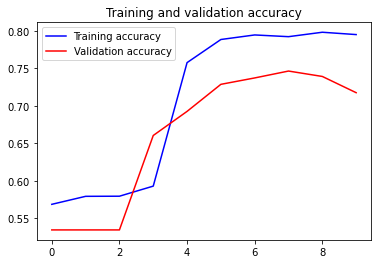

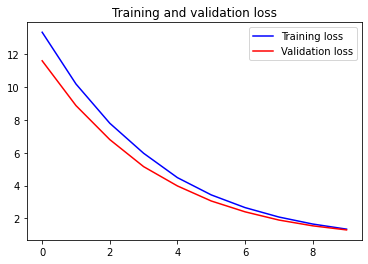

In [15]:
# Visualize training results
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
text = df_test['keyword_text']
x_test = tokenizer.texts_to_sequences(text.values)
x_test = pad_sequences(x_test, maxlen=256)

In [17]:
preds = model.predict(x_test)
pred = [1 if i>0.5 else 0 for i in preds]

In [18]:
submission=pd.DataFrame()
submission['id'] = df_test['id']
submission['target'] = pred
submission.to_csv("predictions.csv",index=False)

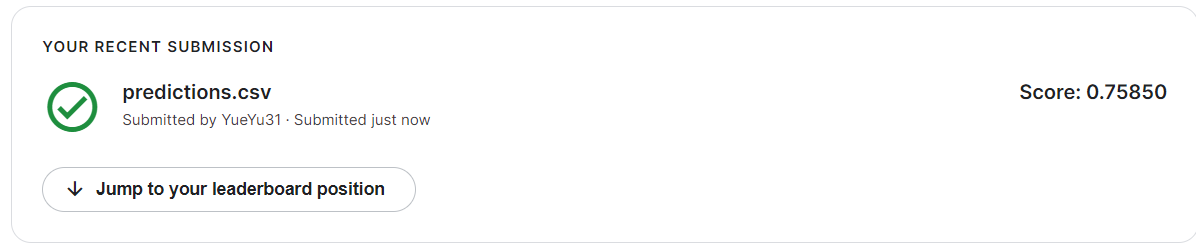

## RNN 2 (4 LSTM + 10 Epochs + 256 Max Shape) 

In [26]:
# build model
model_2 = Sequential(name='Bidirectional_RNN')
model_2.add(Embedding(1000, 256, input_length = 256))
model_2.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_2.add(Dropout(0.5))
    
model_2.add(Bidirectional(LSTM(64, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_2.add(Dropout(0.5))
    
model_2.add(Bidirectional(LSTM(32, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_2.add(Dropout(0.5))

model_2.add(Bidirectional(LSTM(16, return_sequences = False, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_2.add(Dropout(0.4))

model_2.add(Dense(256, activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(16, activation = 'relu'))
model_2.add(Dropout(0.1))
    
model_2.add(Dense(1, activation = 'sigmoid'))
print(model_2.summary())
 
model_2.compile(
optimizer=Adam(learning_rate=0.0001),
loss='binary_crossentropy',
metrics=['Accuracy']
)

Model: "Bidirectional_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 256, 256)          256000    
                                                                 
 bidirectional_30 (Bidirecti  (None, 256, 256)         394240    
 onal)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 256, 256)          0         
                                                                 
 bidirectional_31 (Bidirecti  (None, 256, 128)         164352    
 onal)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 256, 128)          0         
                                                                 
 bidirectional_32 (Bidirecti  (None, 256, 64)    

In [27]:
text = df_train['keyword_text']
tokenizer = Tokenizer(num_words=400)
tokenizer.fit_on_texts(text.values)
x_train = tokenizer.texts_to_sequences(text.values)
x_train = pad_sequences(x_train, maxlen=256)
y_train = df_train['target']

In [28]:
start=datetime.now()
history_2 = model_2.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs = 10
)
end=datetime.now()
rnn_time_2 = end-start

Epoch 1/10
96/96 [==============================] - 150s 1s/step - loss: 14.5298 - Accuracy: 0.5576 - val_loss: 12.7035 - val_Accuracy: 0.5345
Epoch 2/10
96/96 [==============================] - 133s 1s/step - loss: 11.2254 - Accuracy: 0.5790 - val_loss: 9.8407 - val_Accuracy: 0.5345
Epoch 3/10
96/96 [==============================] - 119s 1s/step - loss: 8.7033 - Accuracy: 0.5793 - val_loss: 7.6449 - val_Accuracy: 0.5345
Epoch 4/10
96/96 [==============================] - 119s 1s/step - loss: 6.7721 - Accuracy: 0.5793 - val_loss: 5.9626 - val_Accuracy: 0.5345
Epoch 5/10
96/96 [==============================] - 118s 1s/step - loss: 5.2920 - Accuracy: 0.5791 - val_loss: 4.6776 - val_Accuracy: 0.5345
Epoch 6/10
96/96 [==============================] - 119s 1s/step - loss: 4.1290 - Accuracy: 0.6246 - val_loss: 3.6307 - val_Accuracy: 0.6940
Epoch 7/10
96/96 [==============================] - 118s 1s/step - loss: 3.1995 - Accuracy: 0.7524 - val_loss: 2.8575 - val_Accuracy: 0.7308
Epoch 8/10

In [29]:
print(rnn_time_2)

0:20:36.129627


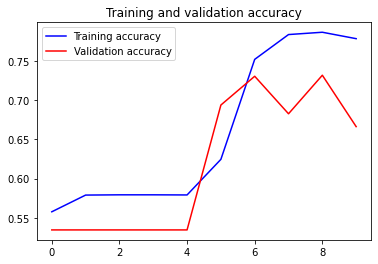

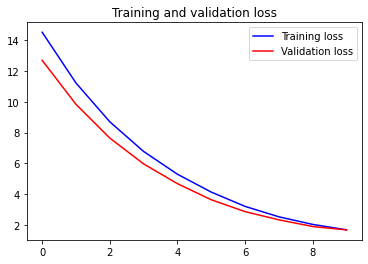

In [30]:
# Visualize training results
acc = history_2.history['Accuracy']
val_acc = history_2.history['val_Accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
text = df_test['keyword_text']
x_test = tokenizer.texts_to_sequences(text.values)
x_test = pad_sequences(x_test, maxlen=256)

In [44]:
preds = model_2.predict(x_test)
pred = [1 if i>0.5 else 0 for i in preds]

In [45]:
submission=pd.DataFrame()
submission['id'] = df_test['id']
submission['target'] = pred
submission.to_csv("predictions-2.csv",index=False)

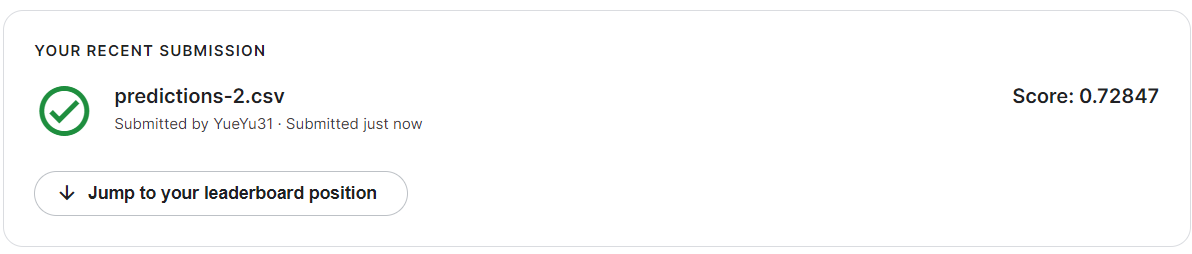

## RNN 3 (3 LSTM + 10 Epochs + 512 Max Shape) 

In [35]:
# build model
model_3 = Sequential(name='Bidirectional_RNN')
model_3.add(Embedding(1000, 512, input_length = 512))
model_3.add(Bidirectional(LSTM(256, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_3.add(Dropout(0.5))
    
model_3.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_3.add(Dropout(0.5))
    
model_3.add(Bidirectional(LSTM(64, return_sequences = False, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_3.add(Dropout(0.4))

model_3.add(Dense(512, activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(16, activation = 'relu'))
model_3.add(Dropout(0.1))
    
model_3.add(Dense(1, activation = 'sigmoid'))
print(model_3.summary())
 
model_3.compile(
optimizer=Adam(learning_rate=0.0001),
loss='binary_crossentropy',
metrics=['Accuracy']
)

Model: "Bidirectional_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 512, 512)          512000    
                                                                 
 bidirectional_37 (Bidirecti  (None, 512, 512)         1574912   
 onal)                                                           
                                                                 
 dropout_42 (Dropout)        (None, 512, 512)          0         
                                                                 
 bidirectional_38 (Bidirecti  (None, 512, 256)         656384    
 onal)                                                           
                                                                 
 dropout_43 (Dropout)        (None, 512, 256)          0         
                                                                 
 bidirectional_39 (Bidirecti  (None, 128)        

In [36]:
text = df_train['keyword_text']
tokenizer = Tokenizer(num_words=400)
tokenizer.fit_on_texts(text.values)
x_train = tokenizer.texts_to_sequences(text.values)
x_train = pad_sequences(x_train, maxlen=512)
y_train = df_train['target']

In [37]:
start=datetime.now()
history_3 = model_3.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs = 10
)
end=datetime.now()
rnn_time_3 = end-start

Epoch 1/10
96/96 [==============================] - 1073s 11s/step - loss: 24.6368 - Accuracy: 0.5772 - val_loss: 20.0366 - val_Accuracy: 0.5345
Epoch 2/10
96/96 [==============================] - 1228s 13s/step - loss: 16.6038 - Accuracy: 0.5793 - val_loss: 13.4956 - val_Accuracy: 0.5345
Epoch 3/10
96/96 [==============================] - 1287s 13s/step - loss: 11.1237 - Accuracy: 0.6465 - val_loss: 8.9697 - val_Accuracy: 0.7479
Epoch 4/10
96/96 [==============================] - 1297s 14s/step - loss: 7.4080 - Accuracy: 0.7764 - val_loss: 6.0639 - val_Accuracy: 0.7354
Epoch 5/10
96/96 [==============================] - 1291s 13s/step - loss: 5.0010 - Accuracy: 0.7852 - val_loss: 4.1520 - val_Accuracy: 0.7190
Epoch 6/10
96/96 [==============================] - 1296s 14s/step - loss: 3.4067 - Accuracy: 0.7947 - val_loss: 2.9306 - val_Accuracy: 0.7078
Epoch 7/10
96/96 [==============================] - 1301s 14s/step - loss: 2.3741 - Accuracy: 0.7951 - val_loss: 2.0599 - val_Accuracy: 0

In [38]:
print(rnn_time_3)

3:31:29.816766


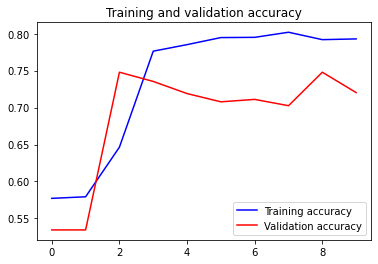

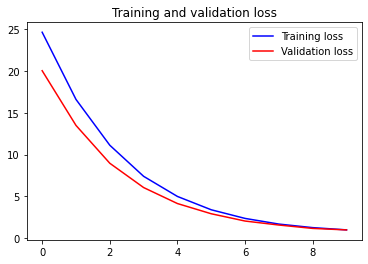

In [39]:
# Visualize training results
acc = history_3.history['Accuracy']
val_acc = history_3.history['val_Accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
text = df_test['keyword_text']
x_test = tokenizer.texts_to_sequences(text.values)
x_test = pad_sequences(x_test, maxlen=512)

In [41]:
preds = model_3.predict(x_test)
pred = [1 if i>0.5 else 0 for i in preds]

In [42]:
submission=pd.DataFrame()
submission['id'] = df_test['id']
submission['target'] = pred
submission.to_csv("predictions-3.csv",index=False)

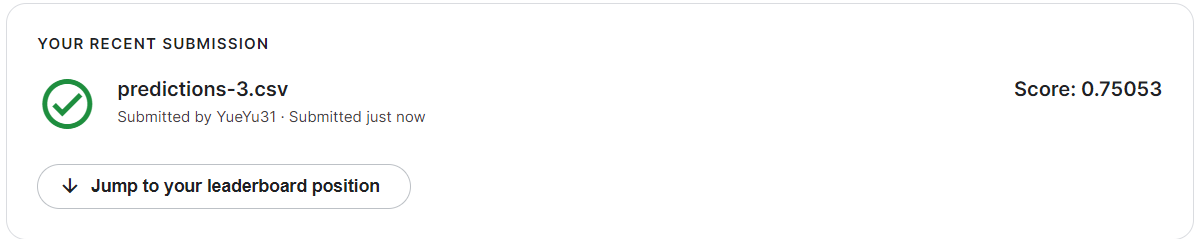

## RNN 4 (3 LSTM + 20 Epochs + 256 Max Shape) 

In [48]:
# build model
model_4 = Sequential(name='Bidirectional_RNN')
model_4.add(Embedding(1000, 256, input_length = 256))
model_4.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_4.add(Dropout(0.5))
    
model_4.add(Bidirectional(LSTM(64, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_4.add(Dropout(0.5))
    
model_4.add(Bidirectional(LSTM(32, return_sequences = False, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_4.add(Dropout(0.4))

model_4.add(Dense(256, activation = 'relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(16, activation = 'relu'))
model_4.add(Dropout(0.1))
    
model_4.add(Dense(1, activation = 'sigmoid'))
print(model.summary())
 
model_4.compile(
optimizer=Adam(learning_rate=0.0001),
loss='binary_crossentropy',
metrics=['Accuracy']
)

Model: "Bidirectional_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 256, 256)          256000    
                                                                 
 bidirectional_40 (Bidirecti  (None, 256, 256)         394240    
 onal)                                                           
                                                                 
 dropout_47 (Dropout)        (None, 256, 256)          0         
                                                                 
 bidirectional_41 (Bidirecti  (None, 256, 128)         164352    
 onal)                                                           
                                                                 
 dropout_48 (Dropout)        (None, 256, 128)          0         
                                                                 
 bidirectional_42 (Bidirecti  (None, 64)         

In [47]:
text = df_train['keyword_text']
tokenizer = Tokenizer(num_words=400)
tokenizer.fit_on_texts(text.values)
x_train = tokenizer.texts_to_sequences(text.values)
x_train = pad_sequences(x_train, maxlen=256)
y_train = df_train['target']

In [49]:
start=datetime.now()
history_4 = model_4.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs = 20
)
end=datetime.now()
rnn_time_4 = end-start

Epoch 1/20
96/96 [==============================] - 158s 2s/step - loss: 13.3377 - Accuracy: 0.5785 - val_loss: 11.6039 - val_Accuracy: 0.5345
Epoch 2/20
96/96 [==============================] - 141s 1s/step - loss: 10.1906 - Accuracy: 0.5793 - val_loss: 8.8733 - val_Accuracy: 0.5345
Epoch 3/20
96/96 [==============================] - 128s 1s/step - loss: 7.7983 - Accuracy: 0.5793 - val_loss: 6.7981 - val_Accuracy: 0.5345
Epoch 4/20
96/96 [==============================] - 128s 1s/step - loss: 5.9466 - Accuracy: 0.6217 - val_loss: 5.1449 - val_Accuracy: 0.7032
Epoch 5/20
96/96 [==============================] - 128s 1s/step - loss: 4.4745 - Accuracy: 0.7741 - val_loss: 3.9358 - val_Accuracy: 0.7571
Epoch 6/20
96/96 [==============================] - 127s 1s/step - loss: 3.4299 - Accuracy: 0.7916 - val_loss: 3.0544 - val_Accuracy: 0.7472
Epoch 7/20
96/96 [==============================] - 128s 1s/step - loss: 2.6583 - Accuracy: 0.7936 - val_loss: 2.3860 - val_Accuracy: 0.7571
Epoch 8/20

In [50]:
print(rnn_time_4)

0:43:35.798300


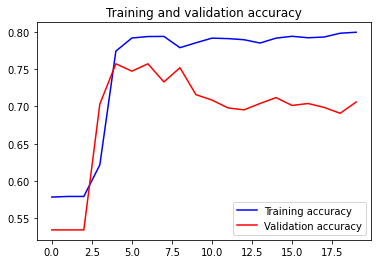

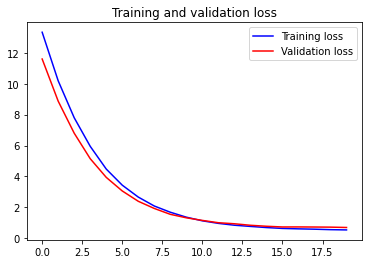

In [51]:
# Visualize training results
acc = history_4.history['Accuracy']
val_acc = history_4.history['val_Accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
text = df_test['keyword_text']
x_test = tokenizer.texts_to_sequences(text.values)
x_test = pad_sequences(x_test, maxlen=256)

In [53]:
preds = model_4.predict(x_test)
pred = [1 if i>0.5 else 0 for i in preds]

In [54]:
submission=pd.DataFrame()
submission['id'] = df_test['id']
submission['target'] = pred
submission.to_csv("predictions-4.csv",index=False)

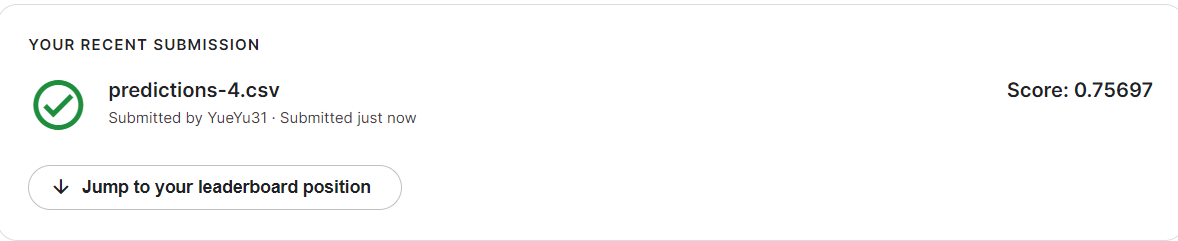

## Conclusion

In [55]:
data = [[3,10,256,rnn_time,0.7952,0.7177], 
        [4,10,256,rnn_time_2,0.7788,0.6664], 
        [3,10,512,rnn_time_3,0.7929,0.7203], 
        [3,20,256,rnn_time_4,0.7993,0.6889]]

In [56]:
con_df = pd.DataFrame(data, columns = ['LSTM Layers','Epochs', 'Max Shape','Time','Training Accuracy','Testing Accuracy'])
con_df

,LSTM Layers,Epochs,Max Shape,Time,Training Accuracy,Testing Accuracy
0,3,10,256,0 days 00:23:00.737336,0.7952,0.7177
1,4,10,256,0 days 00:20:36.129627,0.7788,0.6664
2,3,10,512,0 days 03:31:29.816766,0.7929,0.7203
3,3,20,256,0 days 00:43:35.798300,0.7993,0.6889


This assignment was mainly tired on predicting the model in Bidirectional RNN LSTM. Check the accuracy of prediction by changing LSTM Layers, Epochs, and Max Shape variables. According to the experimental results, too many LSTM Layers may harm accuracy, so there is no need to pursue too many LSTM Layers. It can be seen from the accuracy trend charts that when Epochs is greater than a number (2 to 5), the essential accuracy will have a qualitative leap, but the impact of Epochs on accuracy will not be much later. Max Shape is an interesting parameter. Because tweets have a word limit and generally tweet text is not long, too large Max Shape will increase the learning burden of modeling and will not significantly impact the results. 

According to the table above, each parameter should not be extensive. Excessive parameters will only increase the burden of hardware and reduce efficiency. To improve accuracy, there are only two choices. One is to do more precise clean work for the original text. The other is to experiment with an RNN model different from LSTM. Since I didn't have a chance to use either method, I didn't see a significant increase in my predicted score on Kaggle. 